In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('..\..\data\interim\gurgaon_properties_cleaned_v1.csv')

In [4]:
df.duplicated().sum()

np.int64(122)

In [5]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']"


## 1. areaWithType

In [6]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
3197,0.45,625.0,Carpet area: 625 (58.06 sq.m.)
3050,4.49,3880.0,Super Built up area 3880(360.46 sq.m.)
3547,1.30,1930.0,Super Built up area 1930(179.3 sq.m.)
2561,0.40,893.0,Built Up area: 900 (83.61 sq.m.)Carpet area: 602 sq.ft. (55.93 sq.m.)
2490,2.80,1650.0,Carpet area: 1650 (153.29 sq.m.)


There are three type of areas
1. super builtup area : common property (staircase/garden etc) + builtup area 
2. builtup area : carpet area + thickness of walls + balcony
3. carpet area : area of the house

in the case of houses:
1. plot area : total area of the house

in some properties all three areas are given,in some only few are given and in some nothing is given.
<br>

Problem :
1. `area` column is not consistent, therefore it is not reliable.
2. 'areaWithType' column are values are not consistent, some are sqft/sqm

<br>

Solution :
1. drop `area` column, from `areaWithtype` we have to calculate all 3 types of area, and create 3 columns contains corresponding information.
2. all area unit converted into sqft

In [7]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [8]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [9]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [10]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [11]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1269,5.25,house,4500.0,Plot area 1944(180.6 sq.m.)Built Up area: 4650 sq.ft. (432 sq.m.)Carpet area: 4500 sq.ft. (418.06 sq.m.),NaN,4650.0,4500.0
1741,6.75,flat,3395.0,Super Built up area 3395(315.41 sq.m.)Carpet area: 1855 sq.ft. (172.34 sq.m.),3395.0,NaN,1855.0
1512,1.14,flat,1640.0,Super Built up area 1640(152.36 sq.m.),1640.0,NaN,NaN
530,0.96,house,960.0,Plot area 945(87.79 sq.m.),NaN,NaN,NaN
640,1.55,flat,1608.0,Super Built up area 1608(149.39 sq.m.),1608.0,NaN,NaN


In [12]:
df.duplicated().sum()

np.int64(122)

- How many rows are there where we are having all the three types of area

In [13]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [14]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.2,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,NaN,NaN
10,4.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN
15,1.2,house,846.0,Plot area 846(78.6 sq.m.)Built Up area: 846 sq.ft. (78.6 sq.m.),NaN,846.0,NaN
19,5.5,house,1440.0,Plot area 160(133.78 sq.m.),NaN,NaN,NaN
25,9.0,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN


In [15]:
df.isnull().sum()[-3:]

super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

- extract the rows where superbuilltuparea, builtuparea, carpetarea is nan, putting them into seperate dataframe

In [16]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [17]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.2,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,NaN,NaN
10,4.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN
19,5.5,house,1440.0,Plot area 160(133.78 sq.m.),NaN,NaN,NaN
25,9.0,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
26,7.0,house,2475.0,Plot area 275(229.94 sq.m.),NaN,NaN,NaN


- all of these are houses, plot area = builtup area

In [18]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [19]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [20]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [21]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.2,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,1185.51,NaN
10,4.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,150.00,NaN
19,5.5,house,1440.0,Plot area 160(133.78 sq.m.),NaN,160.00,NaN
25,9.0,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
26,7.0,house,2475.0,Plot area 275(229.94 sq.m.),NaN,275.00,NaN


- as we can see value in area and builtup area values are different, it is because builup are is in sqyards.
- 9sqyard = 1sqft
- 10.7sqm = 1sqft

In [22]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0: #means value is in sqyards
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0: #means it is in sqm
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area'] #already in sqft

In [23]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [24]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.2,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,1185.51,NaN
10,4.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,1350.00,NaN
19,5.5,house,1440.0,Plot area 160(133.78 sq.m.),NaN,1440.00,NaN
25,9.0,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
26,7.0,house,2475.0,Plot area 275(229.94 sq.m.),NaN,2475.00,NaN


In [25]:
# update the original dataframe
df.update(all_nan_df)

In [26]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [27]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0


## 2.additionalRoom

There are five types of additional rooms
1. serveant
2. pooja
3. others
4. store
5. study

solution : convert into OHE

In [28]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
store room                                         99
study room,servant room                            99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [29]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [30]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
101,"pooja room,servant room,study room,store room",1,1,1,1,0
1098,not available,0,0,0,0,0
2136,servant room,0,1,0,0,0
2976,others,0,0,0,0,1
2337,"study room,servant room,store room,pooja room",1,1,1,1,0


In [31]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0


## 3. agePossession

descritization of ageposession

In [32]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Dec 2025                 7
Aug 2023                 7
Jun 2024                 7
Nov 2023                 5
Oct 2023                 4
By 2025                  4
Aug 2024                 4
Jul 2024                 4
Sep 2023                 4
Feb 2024                 3
Jan 2025                 3
Nov 2024                 3
May 2024                 3
Jun 2027                 2
Jan 2026                 2
Jul 2027                 2
Aug 2025                 2
Jul 2025                 2
Oct 2025                 2
Dec 2026                 2
Apr 2026                 2
By 2027       

In [33]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [34]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [35]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [36]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,New Property,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0


## 4.furnishDetails

#### Stratergies

stratergy 1:
 you create 18new columns as there is total number of unique items = 18 items, values will be the number of items in the house.

Stratergy 2:
new column called furnishing type that contains values furnished, semifurnished, unfurnished,
Q :but how do we decide what type of furnished each house is having.
Clustering


So, to execute this will have to convert into 18 columns then apply clustering


In [37]:
len(eval(df.iloc[1011]['furnishDetails']))

18

In [38]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
2362,"['5 Wardrobe', '10 Fan', '1 Exhaust Fan', '2 Geyser', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Centrally Air Conditioned', 'Water purifier', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"
3632,"['2 Wardrobe', '1 Fan', '1 Exhaust Fan', '1 Geyser', '1 Light', '5 AC', '1 Chimney', '1 Curtains', '1 Modular Kitchen', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
3269,"['2 Wardrobe', '4 Fan', '3 Geyser', '5 Light', '4 AC', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Water purifier', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center']"
3790,NaN,"['Lift(s)', 'Swimming Pool', 'Park', 'Visitor Parking', 'Fitness Centre / GYM', 'Club house / Community Center']"
34,"['4 Wardrobe', '7 Fan', '1 Exhaust Fan', '5 Geyser', '1 Stove', '12 Light', '5 AC', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [39]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [40]:
furnishings_df.shape

(3803, 19)

In [41]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\vijit_singh\AppData\Local\Temp\ipykernel_15424\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [42]:
furnishings_df.sample(5)

,AC,Geyser,Sofa,Exhaust Fan,TV,Water Purifier,Washing Machine,Microwave,Curtains,Modular Kitchen,Bed,Fan,Fridge,Stove,Chimney,Light,Dining Table,Wardrobe
3713,5,5,0,0,0,0,0,1,0,1,0,5,0,0,1,21,0,0
1274,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2887,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1716,0,3,0,1,0,1,0,0,0,1,0,7,0,0,1,12,0,3
2589,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [43]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [45]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

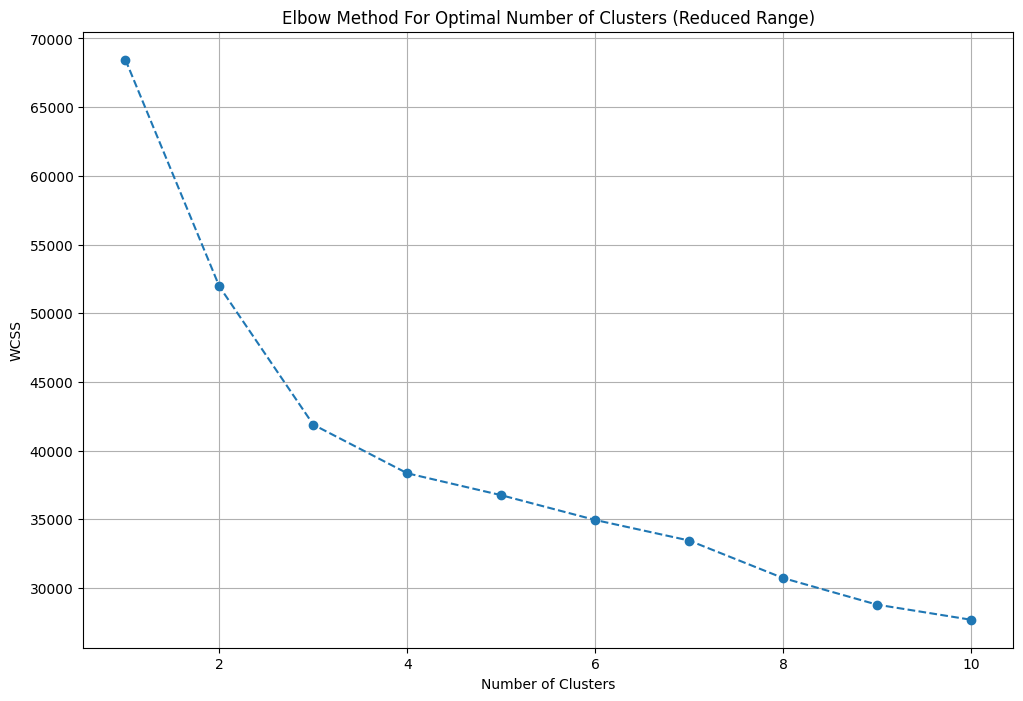

In [46]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [47]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [48]:
df = df.iloc[:,:-18]

In [49]:
df['furnishing_type'] = cluster_assignments

In [50]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
1022,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
3314,"['5 Fan', '1 Exhaust Fan', '5 Geyser', '14 Light', '1 Modular Kitchen', '1 Chimney', '6 Wardrobe', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
3187,"['3 Wardrobe', '2 Bed', '1 Fridge', '1 Dining Table', '1 Geyser', '1 Stove', '8 Light', '1 Modular Kitchen', 'No AC', 'No Chimney', 'No Curtains', 'No Exhaust Fan', 'No Fan', 'No Microwave', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']",0
3676,"['4 Wardrobe', '6 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1
3563,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1


#### PCA

In [51]:
furnishings_df.head()

,AC,Geyser,Sofa,Exhaust Fan,TV,Water Purifier,Washing Machine,Microwave,Curtains,Modular Kitchen,Bed,Fan,Fridge,Stove,Chimney,Light,Dining Table,Wardrobe
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3,0,1,0,0,0,0,4,1,0,6,0,0,1,15,0,3


In [52]:
scaled_data

array([[-0.529074  , -0.50819066, -0.20473839, ..., -0.487417  ,
        -0.19258125, -0.53614847],
       [-0.529074  , -0.50819066, -0.20473839, ..., -0.487417  ,
        -0.19258125, -0.53614847],
       [-0.529074  , -0.50819066, -0.20473839, ..., -0.487417  ,
        -0.19258125, -0.53614847],
       ...,
       [ 0.21668894, -0.06390351, -0.20473839, ...,  0.06876048,
        -0.19258125, -0.15481826],
       [-0.529074  , -0.50819066, -0.20473839, ..., -0.487417  ,
        -0.19258125, -0.53614847],
       [ 1.33533337,  0.82467077, -0.20473839, ...,  1.45920419,
        -0.19258125,  0.60784216]], shape=(3803, 18))

In [53]:
# initializing the pca
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)

In [54]:
new_data = pca.fit_transform(scaled_data)


In [55]:
cluster_assignments

array([1, 1, 1, ..., 2, 1, 2], shape=(3803,), dtype=int32)

In [56]:
pca_df = pd.DataFrame(data=new_data, columns=("1st_principal", "2nd_principal", '3rd_principal'))

pca_df["Label"] = cluster_assignments

pca_df.head()

,1st_principal,2nd_principal,3rd_principal,Label
0,-1.734919,0.552373,0.210783,1
1,-1.734919,0.552373,0.210783,1
2,-1.734919,0.552373,0.210783,1
3,-1.734919,0.552373,0.210783,1
4,2.195442,-2.359173,-0.291636,2


In [57]:
import plotly.express as px
# import plotly.graph_objects as go

px.scatter_3d(pca_df, x="1st_principal", y="2nd_principal", z= '3rd_principal', color="Label")


## 5.features

In [84]:
df[['society','features']].sample(5)

,society,features
1223,dlf regal gardens,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
2610,signature global city 92,NaN
1405,umang winter hills,NaN
1564,dlf city plots phase 2,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Water purifier', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"
3241,imperia the esfera,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"


In [80]:
df['features'].isnull().sum()

np.int64(635)

- we have appartments data, where there is a column called TopFacilities, where all the anemities are given by the society.
- we can merge these two dataset on the basis of scoiety name, and all the TopFacilities which are present in the society data we can put them in this data, by this way some nan values are going to be filled.

In [86]:
import pandas as pd
app_df = pd.read_csv('../../data/raw/appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [87]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [88]:
temp_df = df[df['features'].isnull()]

In [89]:
temp_df.shape

(635, 26)

In [90]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [92]:
x.values

array([nan,
       "['Swimming Pool', 'School', 'ATM', 'Aerobics Centre', 'Restaurant', 'Skating Rink', 'Theatre', 'Wi-Fi Connectivity', 'Pool Table']",
       "['Mini Theatre', 'Foosball', 'Swimming Pool', 'Flower Garden', 'Salon', 'ATM', 'Card Room', 'Piped Gas', 'Grocery Shop']",
       nan, nan,
       "['Bus Shelter', 'Infinity Pool', 'Swimming Pool', 'Bar/Chill-Out Lounge', 'Reflexology Park', 'Aerobics Centre', 'Restaurant', 'Terrace Garden', 'High Speed Elevators']",
       nan,
       "['Swimming Pool', 'Lounge', 'Aerobics Centre', 'Terrace Garden', 'Piped Gas', 'Squash Court', 'Gazebo', 'Wi-Fi Connectivity', 'Sun Deck']",
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       '[\'Jogging Track\', \'24/7 Power Backup\', \'Gated Community\', \'Gymnasium\', \'24/7 Water Supply\', \'Landscape Garden\', "Children\'s Play Area", \'Lift(s)\', \'Car Parking\']',
       "['Swimming Pool', 'Reading Lounge', 'Card Room', 'Sauna', 'Steam Room', 'Cafeteria', 'Billiards', 'Shoppin

In [91]:
df.loc[temp_df.index,'features'] = x.values

In [93]:
df['features'].isnull().sum()

np.int64(481)

- there are total 130 unique anemities
- we can create a new column where it is tell whether it is a
    1. luxury
    2. semiluxry
    3. budget
- first we will do one hot encoding on 130 anemities, that will make each house animities in to vector then whe can cluster it. but this method failed.

- insted of creating as a categorical column, lets create a luxury_score column, where high luxory score int values will tell the more or luxory animities availalbe in society, we will assign weight to each amenity according to its luxury 

#### Strategy 1

In [94]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [95]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [96]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1281,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0
2740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3666,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0
1599,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
105,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [97]:
features_binary_df.shape

(3803, 130)

In [98]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

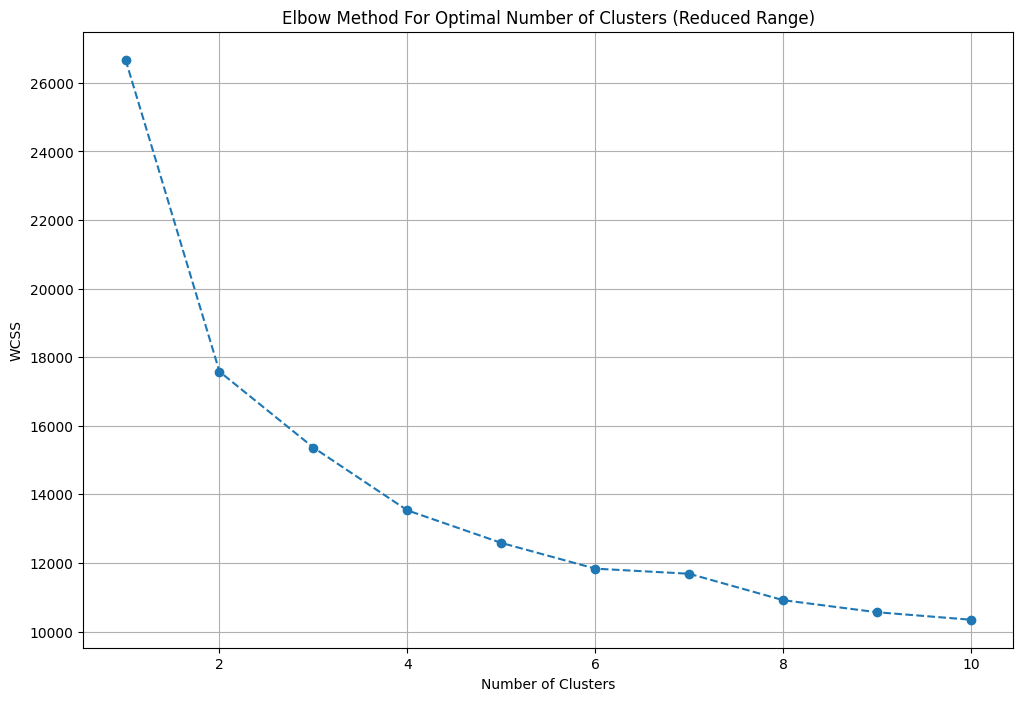

In [99]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

#### Strategy 2

In [100]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [101]:
df['luxury_score'] = luxury_score

In [103]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,New Property,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0,1,"[Lift(s), Park]",8


In [104]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [105]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1911,flat,ambience creacions,sector 22,1.65,11956.0,1380.0,Super Built up area 1380(128.21 sq.m.)Built Up area: 1200 sq.ft. (111.48 sq.m.)Carpet area: 1000 sq.ft. (92.9 sq.m.),2,2,2,9.0,East,Relatively New,1380.0,1200.0,1000.00,0,0,0,1,1,0,133
86,flat,hero homes,sector 104,1.40,15826.0,885.0,Super Built up area 1389(129.04 sq.m.)Carpet area: 884.58 sq.ft. (82.18 sq.m.),3,2,2,4.0,North,Under Construction,1389.0,NaN,884.58,0,0,0,0,0,1,49
1768,flat,supertech new soft launch,sector 68,0.84,7119.0,1180.0,Built Up area: 1180 (109.63 sq.m.),2,2,2,7.0,East,Undefined,NaN,1180.0,NaN,0,0,0,0,0,1,0
2199,flat,signature global the millennia 3,sector 37d,0.50,7142.0,700.0,Carpet area: 700 (65.03 sq.m.),3,3,2,2.0,NaN,Under Construction,NaN,NaN,700.00,0,0,0,0,0,1,31
2219,house,independent,sector 25,10.85,38150.0,2844.0,Plot area 316(264.22 sq.m.),6,6,1,3.0,North-East,Relatively New,NaN,2844.0,NaN,0,0,1,0,0,2,136


In [106]:
df.shape

(3803, 23)

In [555]:
#df.to_csv('gurgaon_properties_cleaned_v2.csv',index=False)